## **0. Introduction & References**
This kernel includes codes and ideas from kernels below. If this kernel helps you, please upvote their work. 
* [Simple Exploration Notebook - QIQC](https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc) by [@sudalairajkumar](https://www.kaggle.com/sudalairajkumar)
* [How to: Preprocessing when using embeddings](https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings) by [@christofhenkel](https://www.kaggle.com/christofhenkel)
* [Improve your Score with some Text Preprocessing](https://www.kaggle.com/theoviel/improve-your-score-with-some-text-preprocessing) by [@theoviel](https://www.kaggle.com/theoviel)
* [A Real Disaster - Leaked Label](https://www.kaggle.com/szelee/a-real-disaster-leaked-label) by [@szelee](https://www.kaggle.com/szelee)

In [16]:
import gc
import re
import string
import operator
from collections import defaultdict

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import STOPWORDS

SEED = 42

In [17]:
df_train = pd.read_csv('../../Data/flip-01/twitter/train.csv', dtype={'id': np.int16, 'target': np.int8})
df_test = pd.read_csv('../../Data/flip-01/twitter/test.csv', dtype={'id': np.int16})

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.20 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.08 MB


## **1. Keyword & Location**

### **1.1 Missing Values**
Both training and test set have same ratio of missing values in `keyword` and `location`.
* **0.8%** of `keyword` is missing in both training and test set
* **33%** of `location` is missing in both training and test set

Since null ratios between training and test set are too close, **they are most probably taken from the same sample**. Missing values in those features are filled with `no_keyword` and `no_location` respectively.

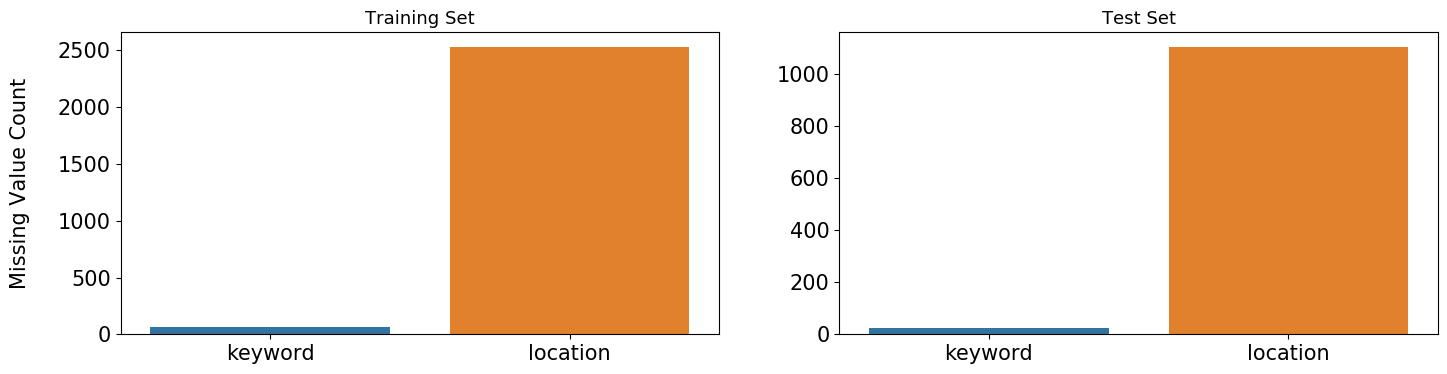

In [18]:
missing_cols = ['keyword', 'location']

fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)

sns.barplot(x=df_train[missing_cols].isnull().sum().index, y=df_train[missing_cols].isnull().sum().values, ax=axes[0])
sns.barplot(x=df_test[missing_cols].isnull().sum().index, y=df_test[missing_cols].isnull().sum().values, ax=axes[1])

axes[0].set_ylabel('Missing Value Count', size=15, labelpad=20)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Training Set', fontsize=13)
axes[1].set_title('Test Set', fontsize=13)

plt.savefig('hits.png', bbox_inches='tight')
plt.show()


for df in [df_train, df_test]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no_{col}')

### **1.2 Cardinality & Target Distribution**
* Locations are not automatically generated, they are user inputs. That's why `location` is very dirty and there are too many unique values in it. It shouldn't be used as a feature.
* Definitely, there is a signal in `keyword` because some of those words can only be used in one context. Keywords have very different tweet counts and target means. `keyword` can be used as a feature by itself or as a word added to the text. Every single keyword in training set exists in test set. If training and test set are from the same sample, it is also possible to use target encoding on `keyword`.

In [19]:
print(f'Number of unique values in keyword = {df_train["keyword"].nunique()} (Training) - {df_test["keyword"].nunique()} (Test)')
print(f'Number of unique values in location = {df_train["location"].nunique()} (Training) - {df_test["location"].nunique()} (Test)')

Number of unique values in keyword = 222 (Training) - 222 (Test)
Number of unique values in location = 3342 (Training) - 1603 (Test)


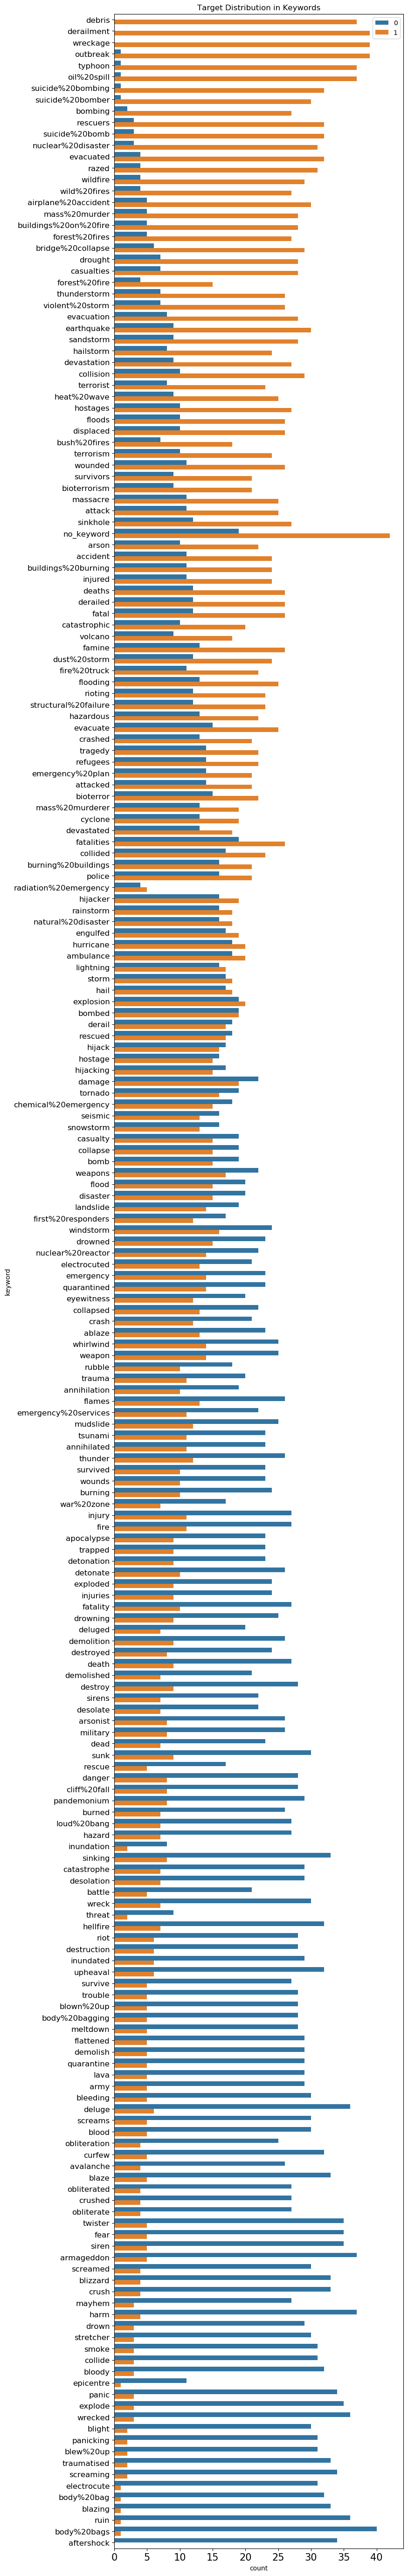

In [20]:
df_train['target_mean'] = df_train.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=df_train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=df_train.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

df_train.drop(columns=['target_mean'], inplace=True)

## **2. Meta Features**
Distributions of meta features in classes and sets can be helpful to identify disaster tweets. It looks like disaster tweets are written in a more formal way with longer words compared to non-disaster tweets because most of them are coming from news agencies. Non-disaster tweets have more typos than disaster tweets because they are coming from individual users. The meta features used for the analysis are;
* `word_count` number of words in text
* `unique_word_count` number of unique words in text
* `stop_word_count` number of stop words in text
* `url_count` number of urls in text
* `mean_word_length` average character count in words
* `char_count` number of characters in text
* `punctuation_count` number of punctuations in text
* `hashtag_count` number of hashtags (**#**) in text
* `mention_count` number of mentions (**@**) in text

In [21]:
# word_count
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
df_test['word_count'] = df_test['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
df_train['unique_word_count'] = df_train['text'].apply(lambda x: len(set(str(x).split())))
df_test['unique_word_count'] = df_test['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
df_train['stop_word_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
df_test['stop_word_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
df_train['url_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
df_test['url_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
df_train['mean_word_length'] = df_train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
df_test['mean_word_length'] = df_test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
df_test['char_count'] = df_test['text'].apply(lambda x: len(str(x)))

# punctuation_count
df_train['punctuation_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
df_test['punctuation_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
df_train['hashtag_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
df_test['hashtag_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
df_train['mention_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
df_test['mention_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

* All of the meta features have very similar distributions in training and test set which also proves that training and test set are taken from the same sample
* All of the meta features have information about target as well, but some of them are not good enough such as `url_count`, `hashtag_count` and `mention_count`
* On the other hand, `word_count`, `unique_word_count`, `stop_word_count`, `mean_word_length`, `char_count`, `punctuation_count` have very different distributions for disaster and non-disaster tweets

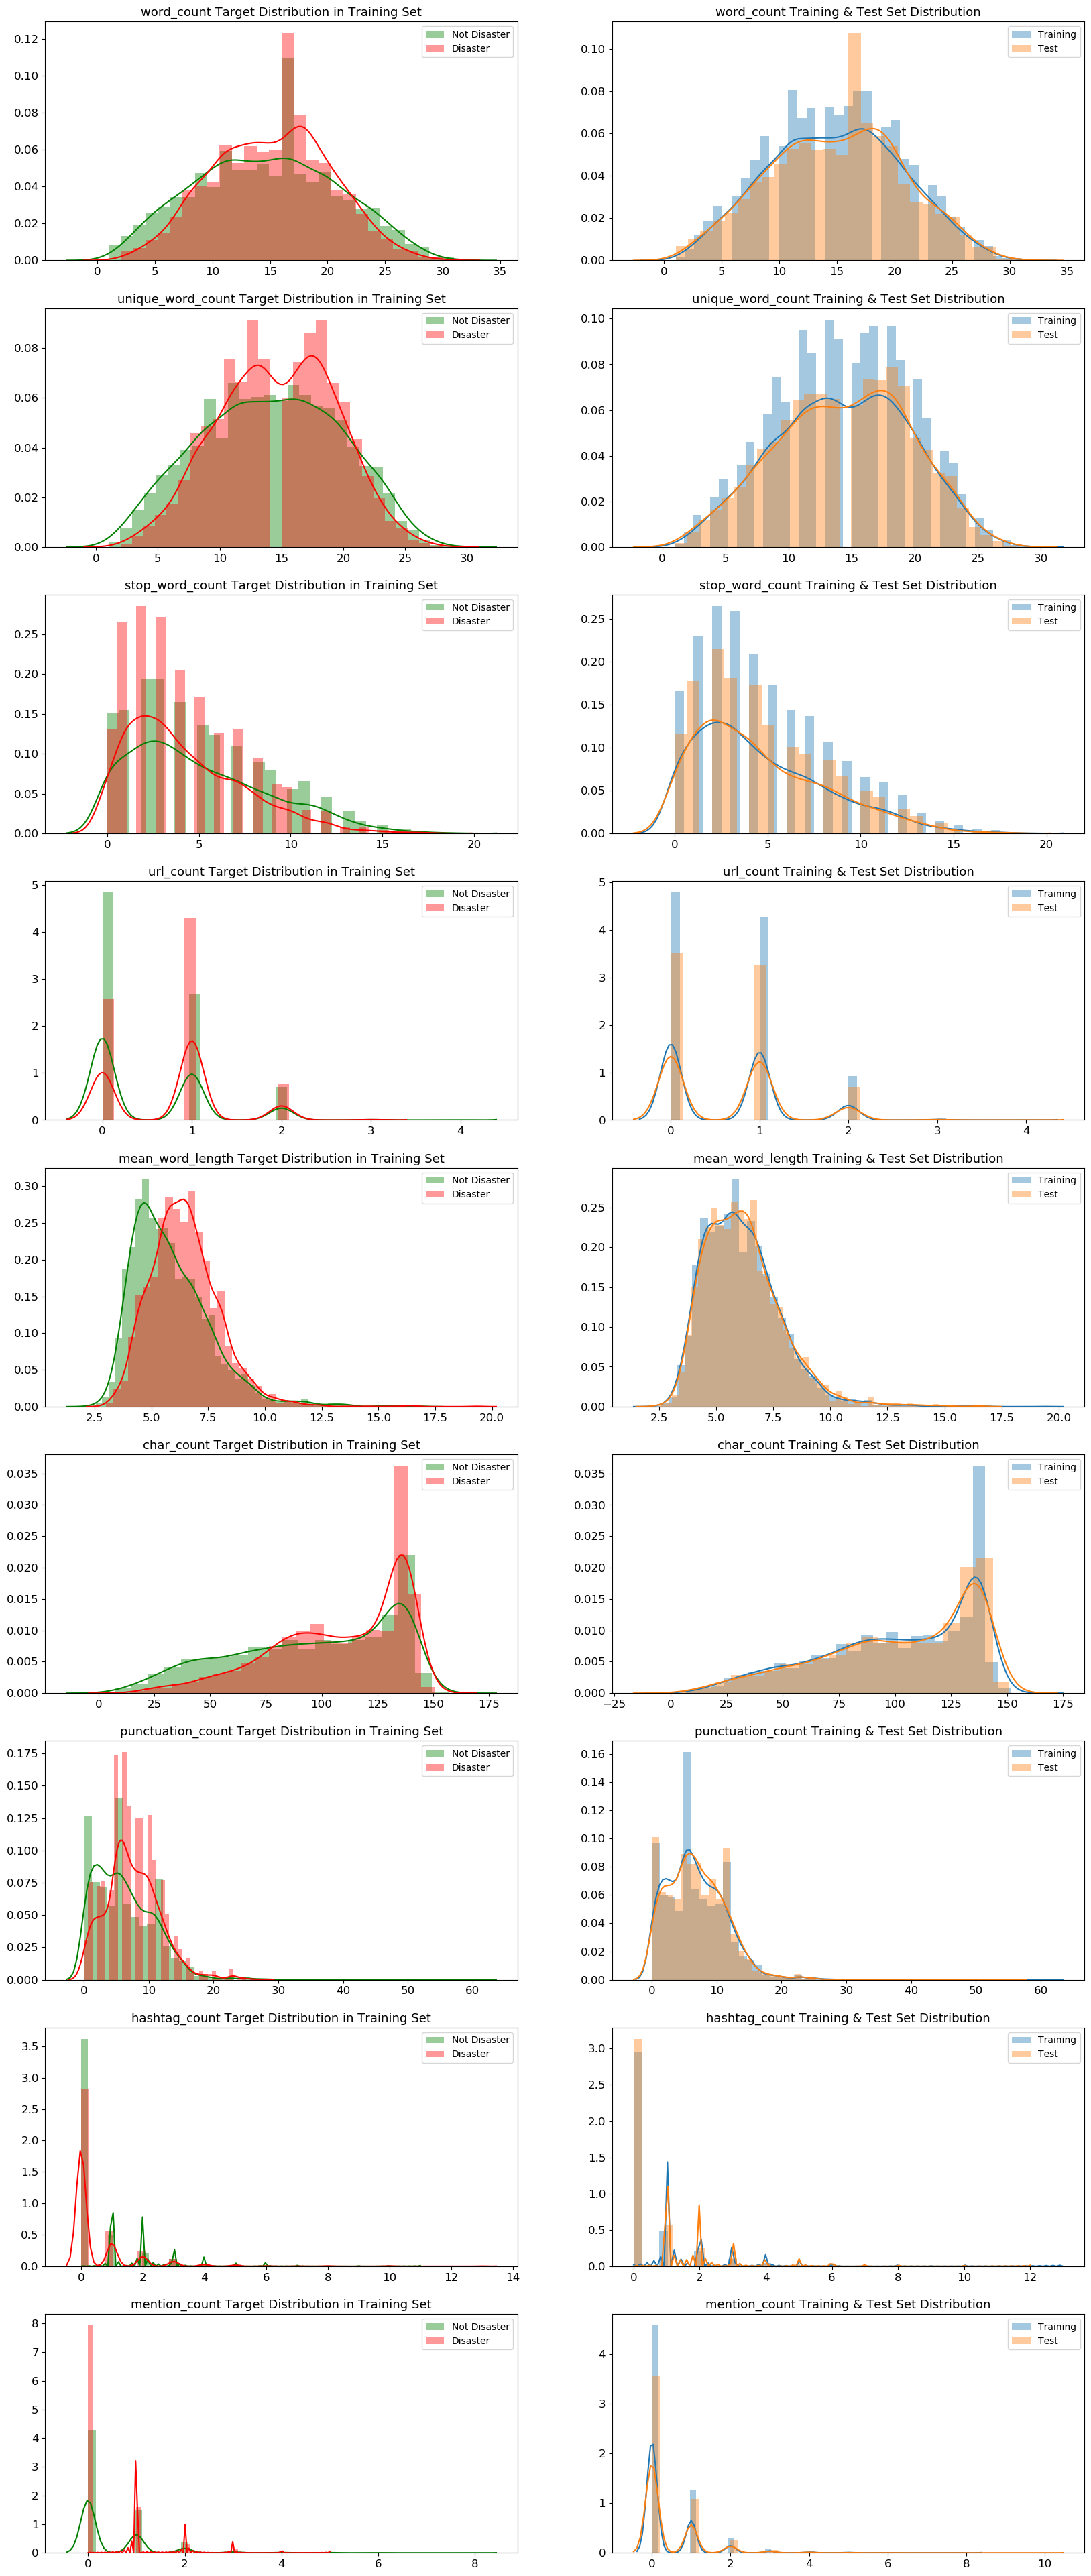

In [22]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']
DISASTER_TWEETS = df_train['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(df_train.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green')
    sns.distplot(df_train.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red')

    sns.distplot(df_train[feature], label='Training', ax=axes[i][1])
    sns.distplot(df_test[feature], label='Test', ax=axes[i][1])
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

## **3. Target & N-grams**

### **3.1 Target**
Class distributions are **57%** for **0** (Not Disaster) and **43%** for **1** (Disaster). Classes are almost equally separated so they don't require any stratification by `target` in cross-validation.

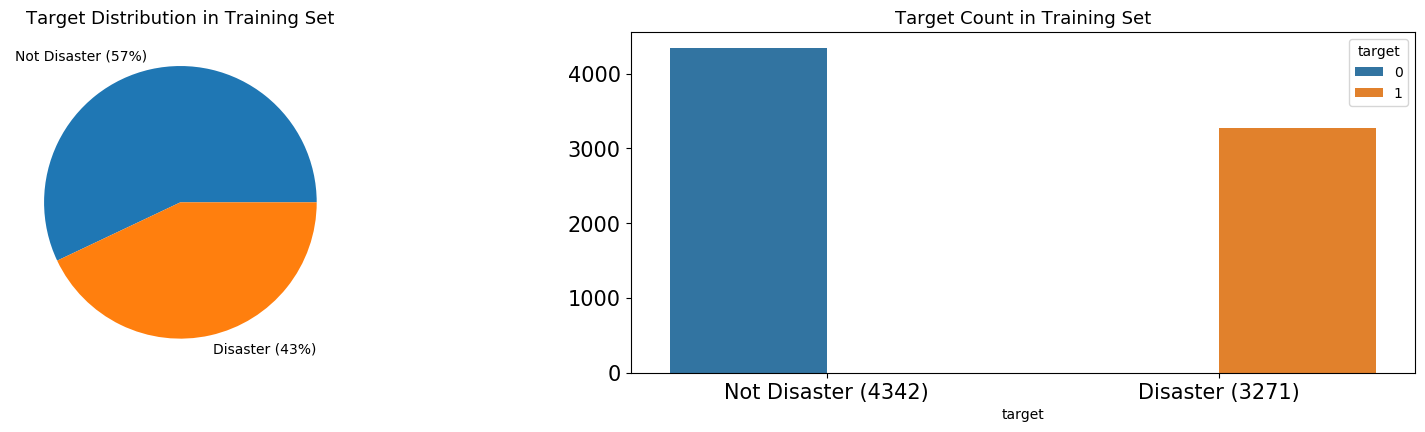

In [23]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

df_train.groupby('target').count()['id'].plot(kind='pie', ax=axes[0], labels=['Not Disaster (57%)', 'Disaster (43%)'])
sns.countplot(x=df_train['target'], hue=df_train['target'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Not Disaster (4342)', 'Disaster (3271)'])
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in Training Set', fontsize=13)
axes[1].set_title('Target Count in Training Set', fontsize=13)

plt.show()

In [24]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

N = 100

# Unigrams
disaster_unigrams = defaultdict(int)
nondisaster_unigrams = defaultdict(int)

for tweet in df_train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        disaster_unigrams[word] += 1
        
for tweet in df_train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        nondisaster_unigrams[word] += 1
        
df_disaster_unigrams = pd.DataFrame(sorted(disaster_unigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_unigrams = pd.DataFrame(sorted(nondisaster_unigrams.items(), key=lambda x: x[1])[::-1])

# Bigrams
disaster_bigrams = defaultdict(int)
nondisaster_bigrams = defaultdict(int)

for tweet in df_train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        disaster_bigrams[word] += 1
        
for tweet in df_train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        nondisaster_bigrams[word] += 1
        
df_disaster_bigrams = pd.DataFrame(sorted(disaster_bigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_bigrams = pd.DataFrame(sorted(nondisaster_bigrams.items(), key=lambda x: x[1])[::-1])

# Trigrams
disaster_trigrams = defaultdict(int)
nondisaster_trigrams = defaultdict(int)

for tweet in df_train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        disaster_trigrams[word] += 1
        
for tweet in df_train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        nondisaster_trigrams[word] += 1
        
df_disaster_trigrams = pd.DataFrame(sorted(disaster_trigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_trigrams = pd.DataFrame(sorted(nondisaster_trigrams.items(), key=lambda x: x[1])[::-1])

### **3.2 Unigrams**
* Most common unigrams exist in **both classes** are mostly punctuations, stop words or numbers. It is better to clean them before modelling since they don't give much information about `target`.
* Most common unigrams in **disaster** tweets are already giving information about disasters. It is very hard to use some of those words in other contexts.
* Most common unigrams in **non-disaster** tweets are verbs. This makes sense because most of those sentences have informal active structure since they are coming from individual users.

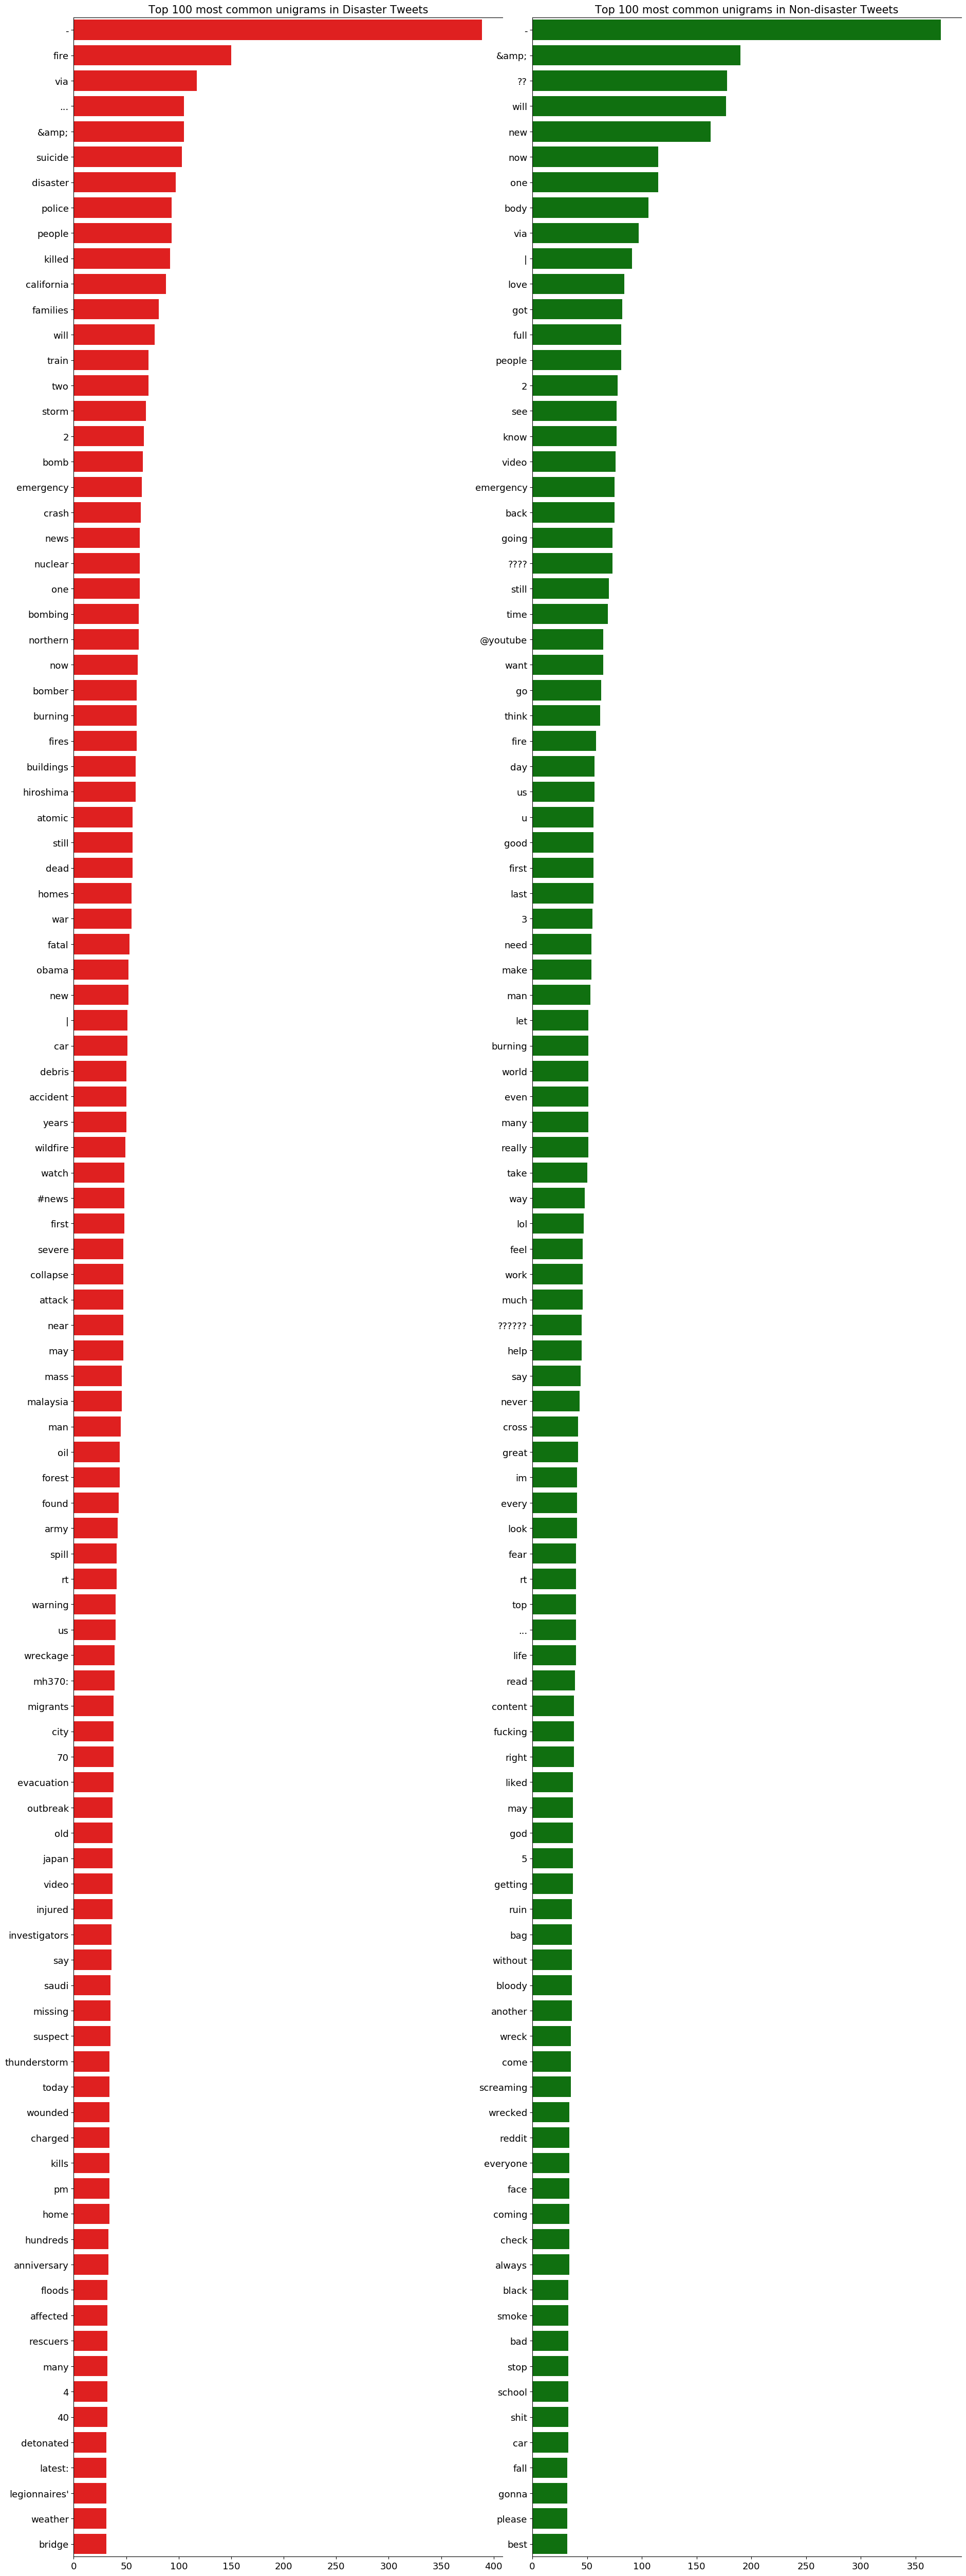

In [25]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_unigrams[0].values[:N], x=df_disaster_unigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_unigrams[0].values[:N], x=df_nondisaster_unigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common unigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in Non-disaster Tweets', fontsize=15)

plt.show()

### **3.3 Bigrams**
* There are no common bigrams exist in **both classes**  because the context is clearer.
* Most common bigrams in **disaster** tweets are giving more information about the disasters than unigrams, but punctuations have to be stripped from words.
* Most common bigrams in **non-disaster** tweets are mostly about reddit or youtube, and they contain lots of punctuations. Those punctuations have to be cleaned out of words as well.

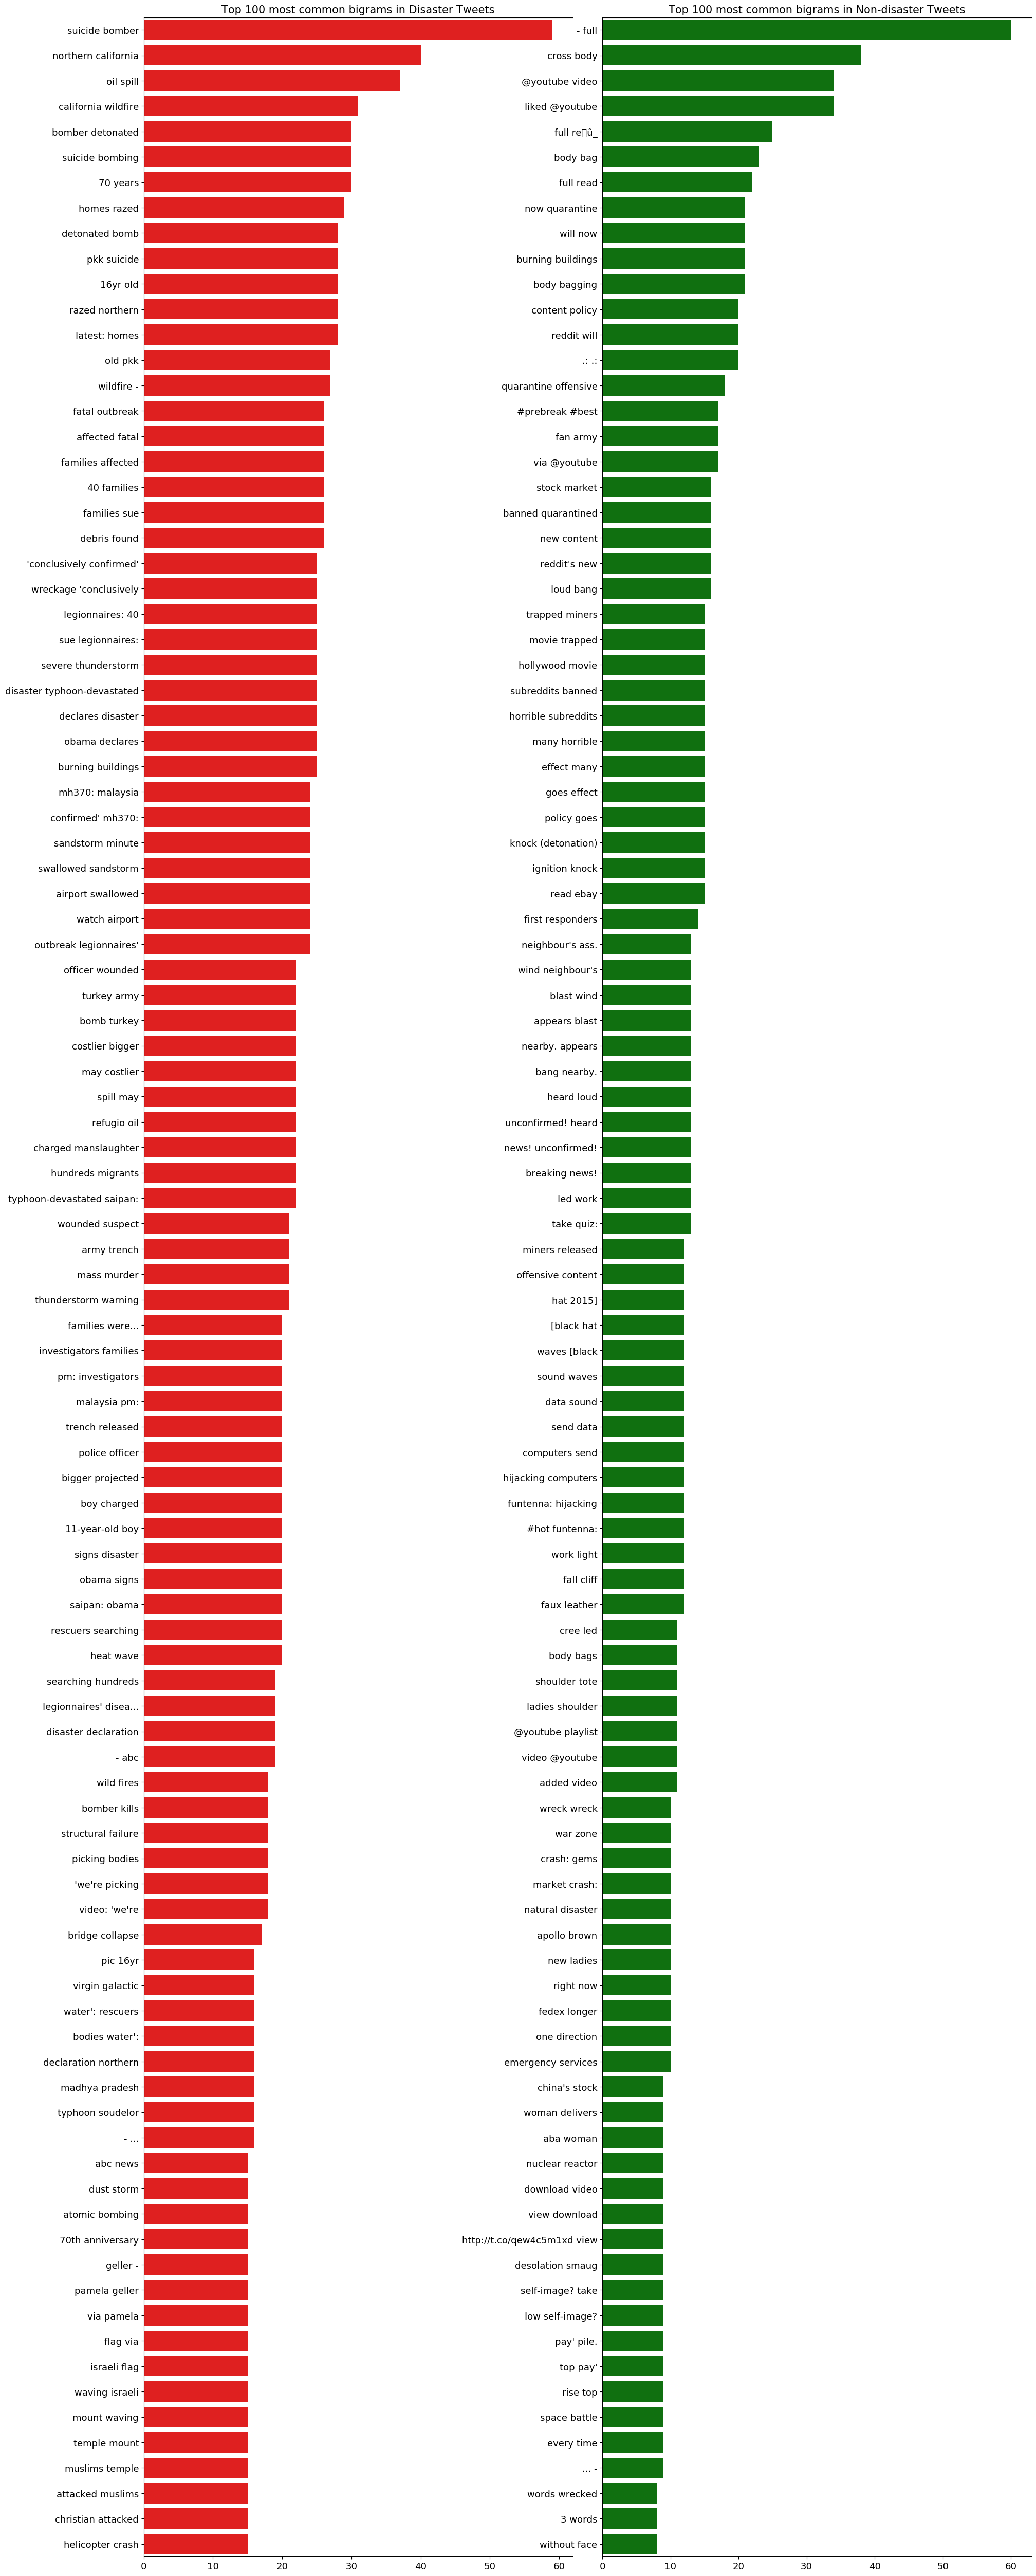

In [26]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_bigrams[0].values[:N], x=df_disaster_bigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_bigrams[0].values[:N], x=df_nondisaster_bigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common bigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common bigrams in Non-disaster Tweets', fontsize=15)

plt.show()

### **3.4 Trigrams**
* There are no common trigrams exist in **both classes**  because the context is clearer.
* Most common trigrams in **disaster** tweets are very similar to bigrams. They give lots of information about disasters, but they may not provide any additional information along with bigrams.
* Most common trigrams in **non-disaster** tweets are also very similar to bigrams, and they contain even more punctuations.

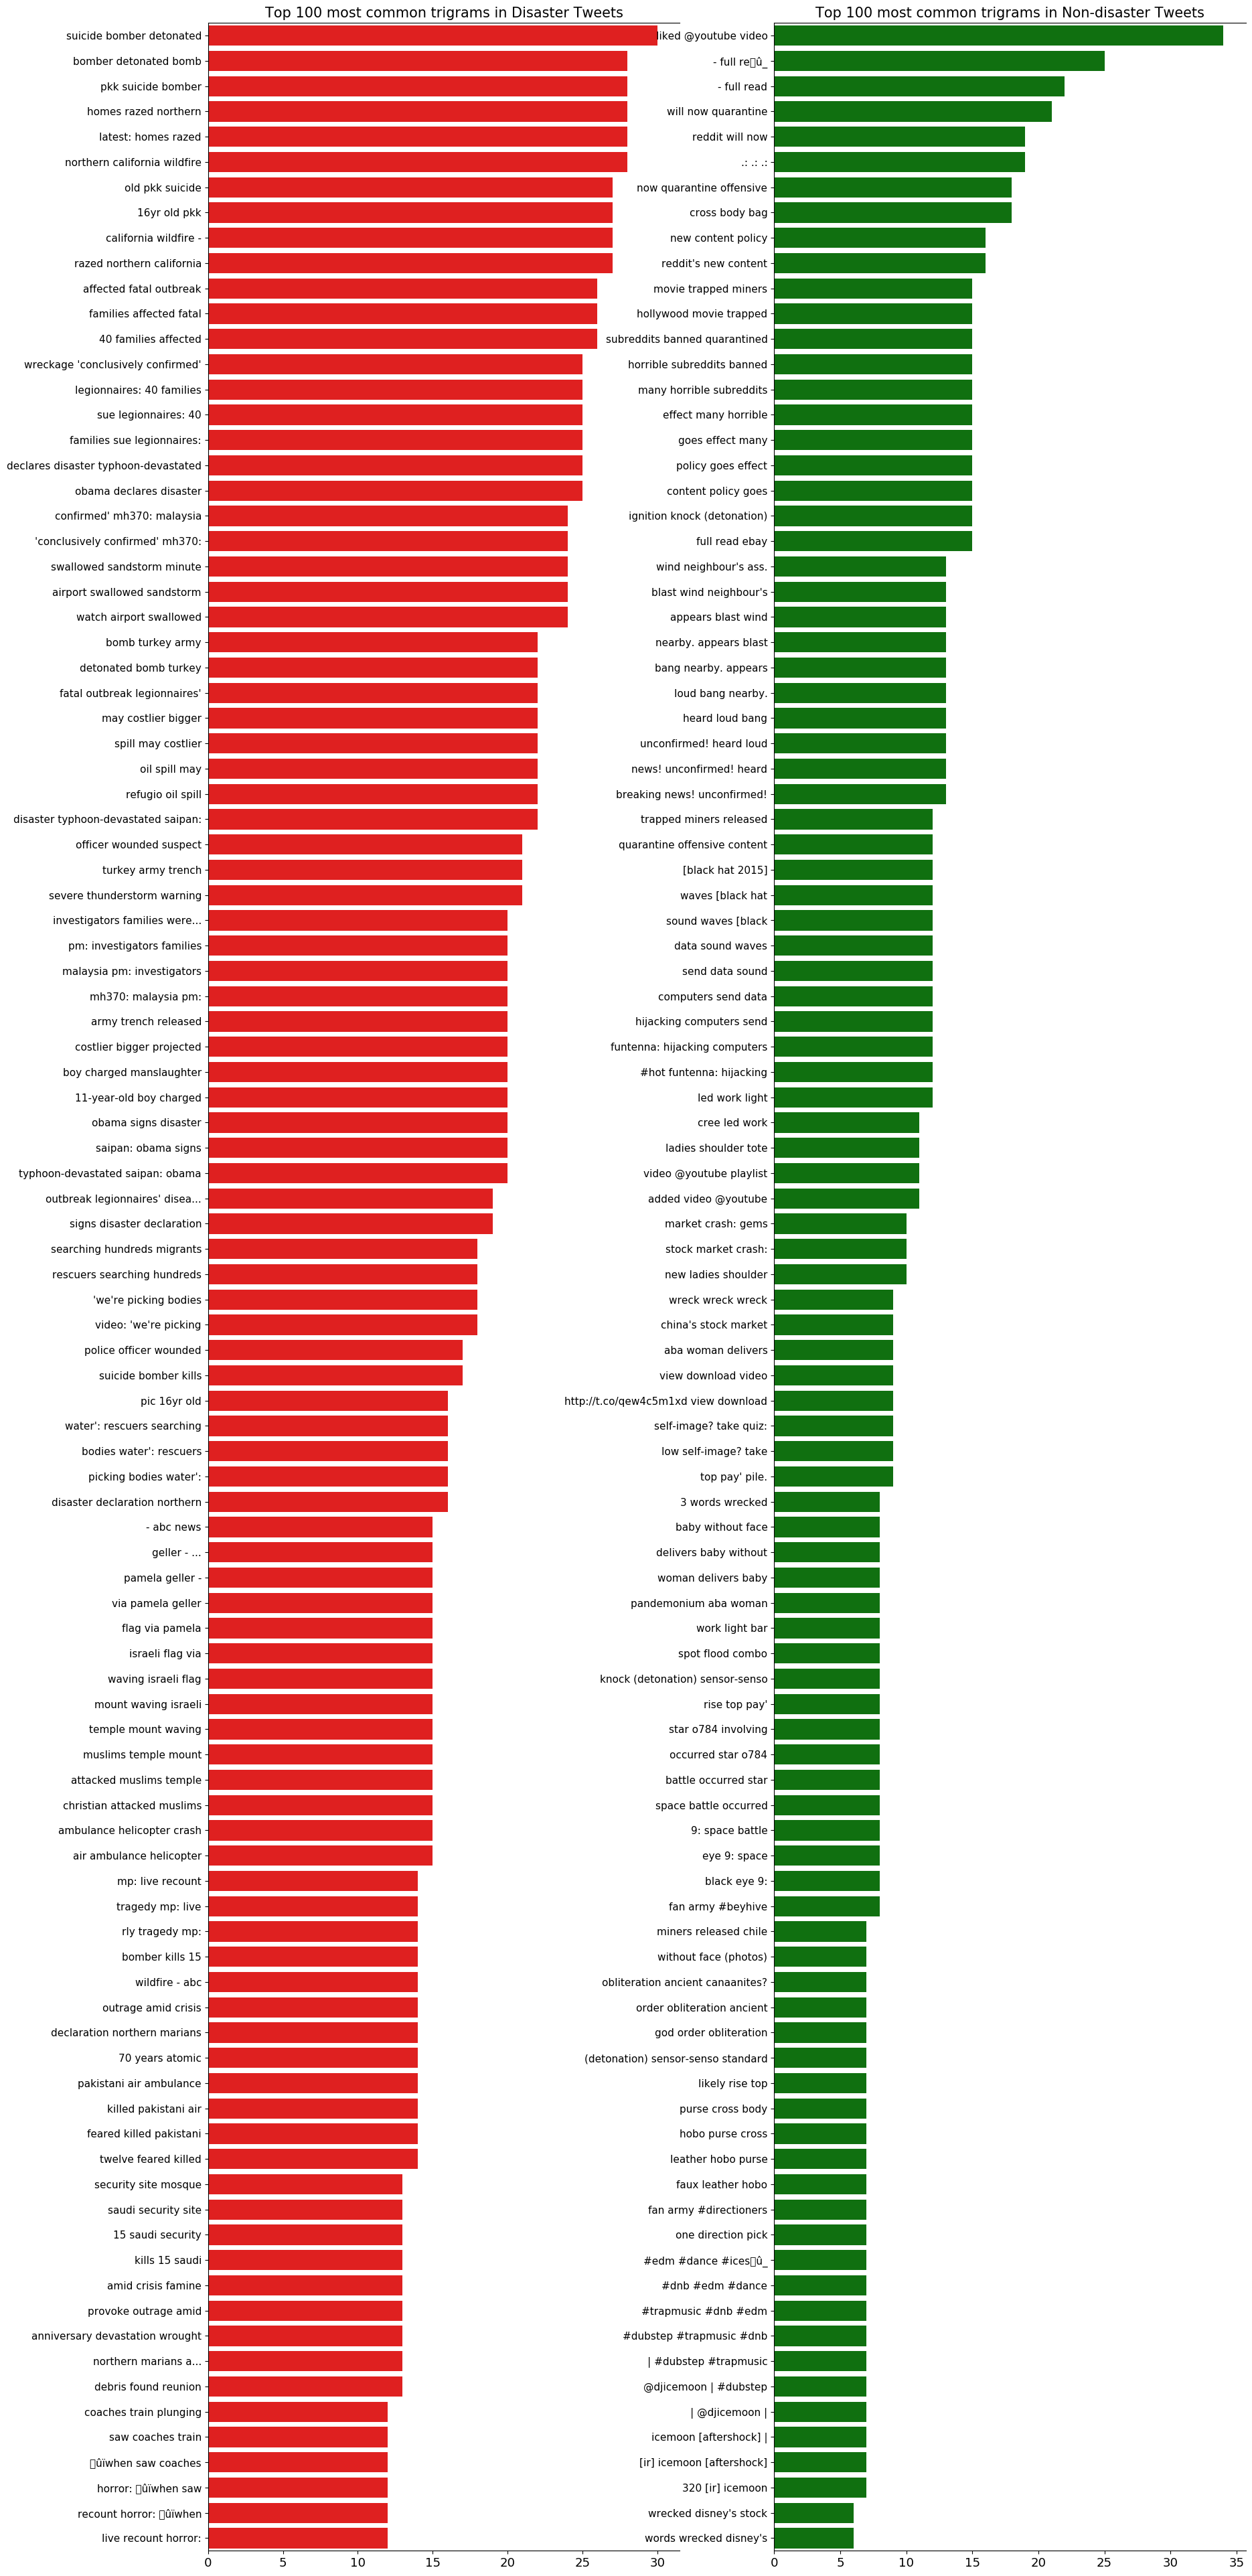

In [27]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 50), dpi=100)

sns.barplot(y=df_disaster_trigrams[0].values[:N], x=df_disaster_trigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_trigrams[0].values[:N], x=df_nondisaster_trigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=11)

axes[0].set_title(f'Top {N} most common trigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common trigrams in Non-disaster Tweets', fontsize=15)

plt.show()

## **4. Embeddings & Text Cleaning**

### **4.1 Embedding Coverage**
* When you have pre-trained embeddings, doing standard preprocessing steps  might not be a good idea because some of the valuable information can be lost. It is better to get vocabulary as close to embeddings as possible. In order to do that, `train_vocab` and `test_vocab` are created by counting the words in tweets.

In [28]:
def build_vocab(tweets):
    vocab = {}        
    for tweet in tweets:
        for word in tweet:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

train_tweets = df_train['text'].apply(lambda s: s.split()).values
train_vocab = build_vocab(train_tweets)
test_tweets = df_test['text'].apply(lambda s: s.split()).values
test_vocab = build_vocab(test_tweets)

Embeddings used for text cleaning are:
* GloVe-300d-840B
* FastText-Crawl-300d-2M

In [29]:
embeddings_glove = np.load('../input/pickled-glove840b300d-for-10sec-loading/glove.840B.300d.pkl', allow_pickle=True)
embeddings_fasttext = np.load('../input/pickled-crawl300d2m-for-kernel-competitions/crawl-300d-2M.pkl', allow_pickle=True)

FileNotFoundError: [Errno 2] No such file or directory: '../input/pickled-glove840b300d-for-10sec-loading/glove.840B.300d.pkl'

Words in intersection of vocab and embeddings are stored in `covered` along with their counts. Words in vocab that don't exist in embeddings are stored in `oov` along with their counts. `n_covered` and `n_oov` are total number of counts and they are used for calculating coverage percentages.

Both GloVe and FastText embeddings have more than **50%** vocab and **80%** text coverage without cleaning. GloVe and FastText coverage are very close but GloVe has slightly higher coverage.

In [ ]:
def check_coverage(vocab, embeddings, embeddings_name, dataset_name):
    covered = {}
    oov = {}    
    n_covered = 0
    n_oov = 0
    
    for word in vocab:
        try:
            covered[word] = embeddings[word]
            n_covered += vocab[word]
        except:
            oov[word] = vocab[word]
            n_oov += vocab[word]
            
    vocab_coverage = len(covered) / len(vocab)
    text_coverage = (n_covered / (n_covered + n_oov))
    print('{} Embeddings cover {:.2%} of {} vocab'.format(embeddings_name, vocab_coverage, dataset_name))
    print('{} Embeddings cover {:.2%} of {} text'.format(embeddings_name, text_coverage, dataset_name))
    
    sorted_oov = sorted(oov.items(), key=operator.itemgetter(1))[::-1]
    return sorted_oov

train_oov_glove = check_coverage(train_vocab, embeddings_glove, 'GloVe', 'Training')
test_oov_glove = check_coverage(test_vocab, embeddings_glove, 'GloVe', 'Test')
train_oov_fasttext = check_coverage(train_vocab, embeddings_fasttext, 'FastText', 'Training')
test_oov_fasttext = check_coverage(test_vocab, embeddings_fasttext, 'FastText', 'Test')

### **4.2 Text Cleaning**
* The most common type of words in oov have punctuations at the start or end. Those words doesn't have embeddings because of the trailing punctuations. `#`, `@`, `!`, `?`, `(`, `)`,`[`, `]`, `*`, `%`, `...`, `'`, `.`, `:` are separated from words.
* There are special characters in tweets and some of them are attached to words. They are removed completely.
* Contractions are expanded.
* Character entity references are replaced with their actual symbols.
* Typos and slang are corrected, and informal abbreviations are written in their long forms.
* Hashtags and usernames are expanded.

In [ ]:
def clean(tweet):
    
    # Punctuations at the start or end of words    
    for punctuation in "#@!?()[]*%":
        tweet = tweet.replace(punctuation, f' {punctuation} ').strip()
    tweet = tweet.replace('...', ' ... ').strip()
    tweet = tweet.replace("'", " ' ").strip()        
    
    # Special characters
    tweet = re.sub(r"\x89Û_", "", tweet)
    tweet = re.sub(r"\x89ÛÒ", "", tweet)
    tweet = re.sub(r"\x89ÛÓ", "", tweet)
    tweet = re.sub(r"\x89ÛÏWhen", "When", tweet)
    tweet = re.sub(r"\x89ÛÏ", "", tweet)
    tweet = re.sub(r"China\x89Ûªs", "China's", tweet)
    tweet = re.sub(r"let\x89Ûªs", "let's", tweet)
    tweet = re.sub(r"\x89Û÷", "", tweet)
    tweet = re.sub(r"\x89Ûª", "", tweet)
    tweet = re.sub(r"\x89Û\x9d", "", tweet)
    tweet = re.sub(r"å_", "", tweet)
    tweet = re.sub(r"\x89Û¢", "", tweet)
    tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
    tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
    tweet = re.sub(r"åÊ", "", tweet)
    tweet = re.sub(r"åÈ", "", tweet)
    tweet = re.sub(r"JapÌ_n", "Japan", tweet)    
    tweet = re.sub(r"Ì©", "e", tweet)
    tweet = re.sub(r"å¨", "", tweet)
    tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
    
    # Contractions
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
    tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    
    # Character entity references
    tweet = re.sub(r"&gt;", ">", tweet)
    tweet = re.sub(r"&lt;", "<", tweet)
    tweet = re.sub(r"&amp;", "&", tweet)
        
    # Typos, slang and informal abbreviations
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/", "with", tweet)
    tweet = re.sub(r"USAgov", "USA government", tweet)
    tweet = re.sub(r"recentlu", "recently", tweet)
    tweet = re.sub(r"Ph0tos", "Photos", tweet)
    tweet = re.sub(r"exp0sed", "exposed", tweet)
    tweet = re.sub(r"<3", "love", tweet)
    tweet = re.sub(r"amageddon", "armageddon", tweet)
    tweet = re.sub(r"Trfc", "Traffic", tweet)
    tweet = re.sub(r"8/5/2015", "2015-08-05", tweet)
    tweet = re.sub(r"chest/torso", "chest / torso", tweet)
    tweet = re.sub(r"WindStorm", "Wind Storm", tweet)
    tweet = re.sub(r"8/6/2015", "2015-08-06", tweet)
    tweet = re.sub(r"10:38PM", "10:38 PM", tweet)
    tweet = re.sub(r"10:30pm", "10:30 PM", tweet)
    
    # Separating other punctuations
    tweet = re.sub(r"MH370:", "MH370 :", tweet)
    tweet = re.sub(r"PM:", "Prime Minister :", tweet)
    tweet = re.sub(r"Legionnaires:", "Legionnaires :", tweet)
    tweet = re.sub(r"Latest:", "Latest :", tweet)
    tweet = re.sub(r"Crash:", "Crash :", tweet)
    tweet = re.sub(r"News:", "News :", tweet)
    tweet = re.sub(r"derailment:", "derailment :", tweet)
    tweet = re.sub(r"attack:", "attack :", tweet)
    tweet = re.sub(r"Saipan:", "Saipan :", tweet)
    tweet = re.sub(r"Photo:", "Photo :", tweet)
    tweet = re.sub(r"Funtenna:", "Funtenna :", tweet)
    tweet = re.sub(r"quiz:", "quiz :", tweet)
    tweet = re.sub(r"VIDEO:", "VIDEO :", tweet)
    tweet = re.sub(r"MP:", "MP :", tweet)
    tweet = re.sub(r"UTC2015-08-05", "UTC 2015-08-05", tweet)
    tweet = re.sub(r"California:", "California :", tweet)
    tweet = re.sub(r"horror:", "horror :", tweet)
    tweet = re.sub(r"Past:", "Past :", tweet)
    tweet = re.sub(r"Time2015-08-06", "Time 2015-08-06", tweet)
    tweet = re.sub(r"here:", "here :", tweet)
    tweet = re.sub(r"fires.", "fires .", tweet)
    tweet = re.sub(r"Forest:", "Forest :", tweet)
    tweet = re.sub(r"Cramer:", "Cramer :", tweet)
    tweet = re.sub(r"Chile:", "Chile :", tweet)
    tweet = re.sub(r"link:", "link :", tweet)
    tweet = re.sub(r"crash:", "crash :", tweet)
    tweet = re.sub(r"Video:", "Video :", tweet)
    tweet = re.sub(r"Bestnaijamade:", "bestnaijamade :", tweet)
    tweet = re.sub(r"NWS:", "National Weather Service :", tweet)
    tweet = re.sub(r".caught", ". caught", tweet)
    tweet = re.sub(r"Hobbit:", "Hobbit :", tweet)
    tweet = re.sub(r"2015:", "2015 :", tweet)
    tweet = re.sub(r"post:", "post :", tweet)
    tweet = re.sub(r"BREAKING:", "BREAKING :", tweet)
    tweet = re.sub(r"Island:", "Island :", tweet)
    tweet = re.sub(r"Med:", "Med :", tweet)
    tweet = re.sub(r"97/Georgia", "97 / Georgia", tweet)
    tweet = re.sub(r"Here:", "Here :", tweet)
    tweet = re.sub(r"horror;", "horror ;", tweet)
    tweet = re.sub(r"people;", "people ;", tweet)
    tweet = re.sub(r"refugees;", "refugees ;", tweet)
    tweet = re.sub(r"Genocide;", "Genocide ;", tweet)
    tweet = re.sub(r".POTUS", ". POTUS", tweet)
    tweet = re.sub(r"Collision-No", "Collision - No", tweet)
    tweet = re.sub(r"Rear-", "Rear -", tweet)
    tweet = re.sub(r"Broadway:", "Broadway :", tweet)
    tweet = re.sub(r"Correction:", "Correction :", tweet)
    tweet = re.sub(r"UPDATE:", "UPDATE :", tweet)
    tweet = re.sub(r"Times:", "Times :", tweet)
    tweet = re.sub(r"RT:", "RT :", tweet)
    tweet = re.sub(r"Police:", "Police :", tweet)
    tweet = re.sub(r"Training:", "Training :", tweet)
    tweet = re.sub(r"Hawaii:", "Hawaii :", tweet)
    tweet = re.sub(r"Selfies:", "Selfies :", tweet)
    tweet = re.sub(r"Content:", "Content :", tweet)
    tweet = re.sub(r"101:", "101 :", tweet)
    tweet = re.sub(r"story:", "story :", tweet)
    tweet = re.sub(r"injured:", "injured :", tweet)
    tweet = re.sub(r"poll:", "poll :", tweet)
    tweet = re.sub(r"Guide:", "Guide :", tweet)
    tweet = re.sub(r"Update:", "Update :", tweet)
    tweet = re.sub(r"alarm:", "alarm :", tweet)
    tweet = re.sub(r"floods:", "floods :", tweet)
    tweet = re.sub(r"Flood:", "Flood :", tweet)
    tweet = re.sub(r"MH370;", "MH370 ;", tweet)
    tweet = re.sub(r"life:", "life :", tweet)
    tweet = re.sub(r"crush:", "crush :", tweet)
    tweet = re.sub(r"now:", "now :", tweet)
    tweet = re.sub(r"Vote:", "Vote :", tweet)
    tweet = re.sub(r"Catastrophe.", "Catastrophe .", tweet)
    tweet = re.sub(r"library:", "library :", tweet)
    tweet = re.sub(r"Bush:", "Bush :", tweet)
    tweet = re.sub(r";ACCIDENT", "; ACCIDENT", tweet)
    tweet = re.sub(r"accident:", "accident :", tweet)
    tweet = re.sub(r"Taiwan;", "Taiwan ;", tweet)
    tweet = re.sub(r"Map:", "Map :", tweet)
    tweet = re.sub(r"failure:", "failure :", tweet)
    tweet = re.sub(r"150-Foot", "150 - Foot", tweet)
    tweet = re.sub(r"failure:", "failure :", tweet)
    tweet = re.sub(r"prefer:", "prefer :", tweet)
    tweet = re.sub(r"CNN:", "CNN :", tweet)
    tweet = re.sub(r"Oops:", "Oops :", tweet)
    tweet = re.sub(r"Disco:", "Disco :", tweet)
    tweet = re.sub(r"Disease:", "Disease :", tweet)
    tweet = re.sub(r"Grows:", "Grows :", tweet)
    tweet = re.sub(r"projected:", "projected :", tweet)
    tweet = re.sub(r"Pakistan.", "Pakistan .", tweet)
    tweet = re.sub(r"ministers:", "ministers :", tweet)
    tweet = re.sub(r"Photos:", "Photos :", tweet)
    tweet = re.sub(r"Disease:", "Disease :", tweet)
    tweet = re.sub(r"pres:", "press :", tweet)
    tweet = re.sub(r"winds.", "winds .", tweet)
    tweet = re.sub(r"MPH.", "MPH .", tweet)
    tweet = re.sub(r"PHOTOS:", "PHOTOS :", tweet)
    tweet = re.sub(r"Time2015-08-05", "Time 2015-08-05", tweet)
    tweet = re.sub(r"Denmark:", "Denmark :", tweet)
    tweet = re.sub(r"Articles:", "Articles :", tweet)
    tweet = re.sub(r"Crash:", "Crash :", tweet)
    tweet = re.sub(r"casualties.:", "casualties .:", tweet)
    tweet = re.sub(r"Afghanistan:", "Afghanistan :", tweet)
    tweet = re.sub(r"Day:", "Day :", tweet)
    tweet = re.sub(r"AVERTED:", "AVERTED :", tweet)
    tweet = re.sub(r"sitting:", "sitting :", tweet)
    tweet = re.sub(r"Multiplayer:", "Multiplayer :", tweet)
    tweet = re.sub(r"Kaduna:", "Kaduna :", tweet)
    tweet = re.sub(r"favorite:", "favorite :", tweet)
    tweet = re.sub(r"home:", "home :", tweet)
    tweet = re.sub(r"just:", "just :", tweet)
    tweet = re.sub(r"Collision-1141", "Collision - 1141", tweet)
    tweet = re.sub(r"County:", "County :", tweet)
    tweet = re.sub(r"Duty:", "Duty :", tweet)
    tweet = re.sub(r"page:", "page :", tweet)
    tweet = re.sub(r"Attack:", "Attack :", tweet)
    tweet = re.sub(r"Minecraft:", "Minecraft :", tweet)
    tweet = re.sub(r"wounds;", "wounds ;", tweet)
    tweet = re.sub(r"Shots:", "Shots :", tweet)
    tweet = re.sub(r"shots:", "shots :", tweet)
    tweet = re.sub(r"Gunfire:", "Gunfire :", tweet)
    tweet = re.sub(r"hike:", "hike :", tweet)
    tweet = re.sub(r"Email:", "Email :", tweet)
    tweet = re.sub(r"System:", "System :", tweet)
    tweet = re.sub(r"Radio:", "Radio :", tweet)
    tweet = re.sub(r"King:", "King :", tweet)
    tweet = re.sub(r"upheaval:", "upheaval :", tweet)
    tweet = re.sub(r"tragedy;", "tragedy ;", tweet)
    tweet = re.sub(r"HERE:", "HERE :", tweet)
    tweet = re.sub(r"terrorism:", "terrorism :", tweet)
    tweet = re.sub(r"police:", "police :", tweet)
    tweet = re.sub(r"Mosque:", "Mosque :", tweet)
    tweet = re.sub(r"Rightways:", "Rightways :", tweet)
    tweet = re.sub(r"Brooklyn:", "Brooklyn :", tweet)
    tweet = re.sub(r"Arrived:", "Arrived :", tweet)
    tweet = re.sub(r"Home:", "Home :", tweet)
    tweet = re.sub(r"Earth:", "Earth :", tweet)
    tweet = re.sub(r"three:", "three :", tweet)
    
    # Hashtags and usernames
    tweet = re.sub(r"IranDeal", "Iran Deal", tweet)
    tweet = re.sub(r"ArianaGrande", "Ariana Grande", tweet)
    tweet = re.sub(r"camilacabello97", "camila cabello", tweet) 
    tweet = re.sub(r"RondaRousey", "Ronda Rousey", tweet)     
    tweet = re.sub(r"MTVHottest", "MTV Hottest", tweet)
    tweet = re.sub(r"TrapMusic", "Trap Music", tweet)
    tweet = re.sub(r"ProphetMuhammad", "Prophet Muhammad", tweet)
    tweet = re.sub(r"PantherAttack", "Panther Attack", tweet)
    tweet = re.sub(r"StrategicPatience", "Strategic Patience", tweet)
    tweet = re.sub(r"socialnews", "social news", tweet)
    tweet = re.sub(r"NASAHurricane", "NASA Hurricane", tweet)
    tweet = re.sub(r"onlinecommunities", "online communities", tweet)
    tweet = re.sub(r"humanconsumption", "human consumption", tweet)
    tweet = re.sub(r"Typhoon-Devastated", "Typhoon Devastated", tweet)
    tweet = re.sub(r"Meat-Loving", "Meat Loving", tweet)
    tweet = re.sub(r"facialabuse", "facial abuse", tweet)
    tweet = re.sub(r"LakeCounty", "Lake County", tweet)
    tweet = re.sub(r"BeingAuthor", "Being Author", tweet)
    tweet = re.sub(r"withheavenly", "with heavenly", tweet)
    tweet = re.sub(r"thankU", "thank you", tweet)
    tweet = re.sub(r"iTunesMusic", "iTunes Music", tweet)
    tweet = re.sub(r"OffensiveContent", "Offensive Content", tweet)
    tweet = re.sub(r"WorstSummerJob", "Worst Summer Job", tweet)
    tweet = re.sub(r"HarryBeCareful", "Harry Be Careful", tweet)
    tweet = re.sub(r"NASASolarSystem", "NASA Solar System", tweet)
    tweet = re.sub(r"animalrescue", "animal rescue", tweet)
    tweet = re.sub(r"KurtSchlichter", "Kurt Schlichter", tweet)
    tweet = re.sub(r"aRmageddon", "armageddon", tweet)
    tweet = re.sub(r"Throwingknifes", "Throwing knives", tweet)
    tweet = re.sub(r"GodsLove", "God's Love", tweet)
    tweet = re.sub(r"bookboost", "book boost", tweet)
    tweet = re.sub(r"ibooklove", "I book love", tweet)
    tweet = re.sub(r"NestleIndia", "Nestle India", tweet)
    tweet = re.sub(r"realDonaldTrump", "Donald Trump", tweet)
    tweet = re.sub(r"DavidVonderhaar", "David Vonderhaar", tweet)
    tweet = re.sub(r"CecilTheLion", "Cecil The Lion", tweet)
    tweet = re.sub(r"weathernetwork", "weather network", tweet)
    tweet = re.sub(r"withBioterrorism&use", "with Bioterrorism & use", tweet)
    tweet = re.sub(r"Hostage&2", "Hostage & 2", tweet)
    tweet = re.sub(r"GOPDebate", "GOP Debate", tweet)
    tweet = re.sub(r"RickPerry", "Rick Perry", tweet)
    tweet = re.sub(r"frontpage", "front page", tweet)
    tweet = re.sub(r"NewsInTweets", "News In Tweets", tweet)
    tweet = re.sub(r"ViralSpell", "Viral Spell", tweet)
    tweet = re.sub(r"til_now", "until now", tweet)
    tweet = re.sub(r"volcanoinRussia", "volcano in Russia", tweet)
    tweet = re.sub(r"ZippedNews", "Zipped News", tweet)
    tweet = re.sub(r"MicheleBachman", "Michele Bachman", tweet)
    tweet = re.sub(r"53inch", "53 inch", tweet)
    tweet = re.sub(r"KerrickTrial", "Kerrick Trial", tweet)
    tweet = re.sub(r"abstorm", "Alberta Storm", tweet)
    tweet = re.sub(r"Beyhive", "Beyonce hive", tweet)
    tweet = re.sub(r"IDFire", "Idaho Fire", tweet)
    tweet = re.sub(r"DETECTADO", "Detected", tweet)
    tweet = re.sub(r"RockyFire", "Rocky Fire", tweet)
    tweet = re.sub(r"Listen/Buy", "Listen / Buy", tweet)
    tweet = re.sub(r"NickCannon", "Nick Cannon", tweet)
    tweet = re.sub(r"FaroeIslands", "Faroe Islands", tweet)
    tweet = re.sub(r"yycstorm", "Calgary Storm", tweet)
    tweet = re.sub(r"IDPs:", "Internally Displaced People :", tweet)
    tweet = re.sub(r"ArtistsUnited", "Artists United", tweet)
    tweet = re.sub(r"ClaytonBryant", "Clayton Bryant", tweet)
    tweet = re.sub(r"jimmyfallon", "jimmy fallon", tweet)
    
    if 'http' not in tweet:
        tweet = tweet.replace(":", " : ").strip() 
        tweet = tweet.replace(".", " . ").strip() 
          
    return tweet

df_train['text_cleaned'] = df_train['text'].apply(lambda x : clean(x))
df_test['text_cleaned'] = df_test['text'].apply(lambda x : clean(x))

train_tweets_cleaned = df_train['text_cleaned'].apply(lambda s: s.split()).values
train_vocab_cleaned = build_vocab(train_tweets_cleaned)
test_tweets_cleaned = df_test['text_cleaned'].apply(lambda s: s.split()).values
test_vocab_cleaned = build_vocab(test_tweets_cleaned)

train_oov_glove = check_coverage(train_vocab_cleaned, embeddings_glove, 'GloVe', 'Training')
test_oov_glove = check_coverage(test_vocab_cleaned, embeddings_glove, 'GloVe', 'Test')
train_oov_fasttext = check_coverage(train_vocab_cleaned, embeddings_fasttext, 'FastText', 'Training')
test_oov_fasttext = check_coverage(test_vocab_cleaned, embeddings_fasttext, 'FastText', 'Test')

## **5. Mislabeled Samples**
There are **18** unique tweets in training set which are labeled differently in their duplicates. Those tweets are probably labeled by different people and they interpreted the meaning differently because some of them are not very clear. Tweets with two unique `target` values are relabeled since they can affect the training score.

In [ ]:
df_mislabeled = df_train.groupby(['text']).nunique().sort_values(by='target', ascending=False)
df_mislabeled = df_mislabeled[df_mislabeled['target'] > 1]['target']
df_mislabeled

In [ ]:
df_train['target_relabeled'] = df_train['target'].copy() 

df_train.loc[df_train['text'] == 'like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit', 'target_relabeled'] = 0
df_train.loc[df_train['text'] == 'Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife', 'target_relabeled'] = 0
df_train.loc[df_train['text'] == 'To fight bioterrorism sir.', 'target_relabeled'] = 0
df_train.loc[df_train['text'] == '.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4', 'target_relabeled'] = 1
df_train.loc[df_train['text'] == 'CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring', 'target_relabeled'] = 1
df_train.loc[df_train['text'] == '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption', 'target_relabeled'] = 0
df_train.loc[df_train['text'] == 'In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!', 'target_relabeled'] = 0
df_train.loc[df_train['text'] == 'Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE', 'target_relabeled'] = 1
df_train.loc[df_train['text'] == 'RT NotExplained: The only known image of infamous hijacker D.B. Cooper. http://t.co/JlzK2HdeTG', 'target_relabeled'] = 1
df_train.loc[df_train['text'] == "Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "wowo--=== 12000 Nigerian refugees repatriated from Cameroon", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it #islam!", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "Caution: breathing may be hazardous to your health.", 'target_relabeled'] = 1
df_train.loc[df_train['text'] == "I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect", 'target_relabeled'] = 0
df_train.loc[df_train['text'] == "that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time", 'target_relabeled'] = 0

## **6. Test Set Labels**
Test set labels can be found on [this](https://www.figure-eight.com/data-for-everyone/) website. Dataset is named **Disasters on social media**. This is how people are submitting perfect scores. Other "Getting Started" competitions also have their test labels leaked. The main point of "Getting Started" competitions is **learning and sharing**, and perfect score doesn't mean anything. 

> **Phil Culliton wrote:**
> For the AutoML prize, any use of the label set will result in disqualification.

According to [@philculliton](https://www.kaggle.com/philculliton) from Kaggle Team, competitors who use test set labels in any way are not eligible to win AutoML prize. There are no other penalties for using them.

In [ ]:
df_leak = pd.read_csv('../input/nlp-with-disaster-tweets-test-set-with-labels/socialmedia-disaster-tweets-DFE.csv', encoding ='ISO-8859-1')[['choose_one', 'text']]

# Creating target and id
df_leak['target'] = (df_leak['choose_one'] == 'Relevant').astype(np.int8)
df_leak['id'] = df_leak.index.astype(np.int16)
df_leak.drop(columns=['choose_one', 'text'], inplace=True)

# Merging target to test set
df_test = df_test.merge(df_leak, on=['id'], how='left')

print('Leaked Data Set Shape = {}'.format(df_leak.shape))
print('Leaked Data Set Memory Usage = {:.2f} MB'.format(df_leak.memory_usage().sum() / 1024**2))

In [ ]:
TRAIN_ORIGINAL_FEATURES = ['id', 'keyword', 'location', 'text', 'target', 'text_cleaned', 'target_relabeled']
TEST_ORIGINAL_FEATURES = ['id', 'keyword', 'location', 'text', 'target', 'text_cleaned']

df_train[TRAIN_ORIGINAL_FEATURES].to_pickle('train.pkl')
df_test[TEST_ORIGINAL_FEATURES].to_pickle('test.pkl')

submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
submission['target'] = df_test['target'].values
submission.to_csv('submission.csv', index=False)

print('Training Set Shape = {}'.format(df_train[TRAIN_ORIGINAL_FEATURES].shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train[TRAIN_ORIGINAL_FEATURES].memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test[TEST_ORIGINAL_FEATURES].shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test[TEST_ORIGINAL_FEATURES].memory_usage().sum() / 1024**2))